Methods to test:

* joblib.dump with stringIO
* pickle
* msgpack
* numpy.dump

In [1]:
import pickle
import msgpack
import time
import msgpack_numpy as m
import zlib
m.patch()

In [30]:
def dump(obj, method):
    if method == 'pickle':
        return pickle.dumps(obj)
    elif method == 'msgpack':
        return msgpack.packb(obj)
    else:
        raise ValueError('')
def load(obj, method):
    if method == 'pickle':
        return pickle.loads(obj)
    elif method == 'msgpack':
        return msgpack.unpackb(obj)
    else:
        raise ValueError('')
    
def compress(x, leve=0):
    return zlib.compress(x, level=level)
def uncompress(x):
    return zlib.decompress(x)
    
def get_stats(n, method='pickle', level=0):
    x = np.linspace(0, 2*np.pi, num=n)
    y = np.sin(x) + np.random.randn(n) / 4
    pack = {'size': x.shape, 'float': 1.0, 'string': "abcasdf",
            'x': x, 's': np.random.rand(10)}
    start = time.time()
    serial = dump(pack, method)
    ret = {'dump_time': time.time() - start, 'bytes': len(serial)}
    
    start = time.time()
    serial = compress(serial)
    ret = {'compress_time': time.time() - start, 'compressed_bytes': len(serial),
           **ret}
    
    start = time.time()
    serial = uncompress(serial)
    ret = {'decompress_time': time.time() - start, **ret}
    
    start = time.time()
    obj = load(serial, method)
    ret = {'load_time': time.time() - start, **ret}
    
    
    ret['dump_time (us)'] = ret['dump_time'] / 10**-6
    ret['load_time (us)'] = ret['load_time'] / 10**-6
    ret = {'n': n, 'method': method, 'level': level, **ret}
    return ret

In [31]:
import numpy as np
data = []
for repeat in range(100):
    for level in [0, 1, 2]:
        for n in np.logspace(1, 4, num=30, dtype=int):
            for method in ['pickle', 'msgpack']:
                data += [get_stats(n, method=method, level=level)]

In [32]:
import pandas as pd
df = pd.DataFrame(data)
df.head()

,bytes,compress_time,compressed_bytes,decompress_time,dump_time,dump_time (us),level,load_time,load_time (us),method,n
0,436,0.000022,447,0.000009,0.000097,97.036362,0,0.000048,47.922134,pickle,10
1,284,0.000048,295,0.000008,0.000159,159.025192,0,0.000098,97.990036,msgpack,10
2,452,0.000062,463,0.000005,0.000068,68.187714,0,0.000033,32.901764,pickle,12
3,300,0.000023,311,0.000008,0.000046,46.253204,0,0.000031,31.232834,msgpack,12
4,484,0.000016,495,0.000006,0.000049,48.875809,0,0.000028,27.894974,pickle,16


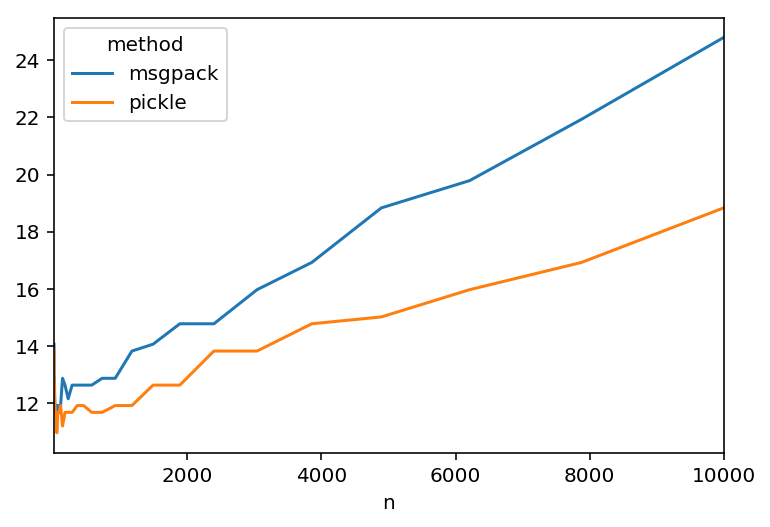

In [33]:
show = df.pivot_table(index='n', columns='method', aggfunc=np.min)
show.plot(y='load_time (us)')

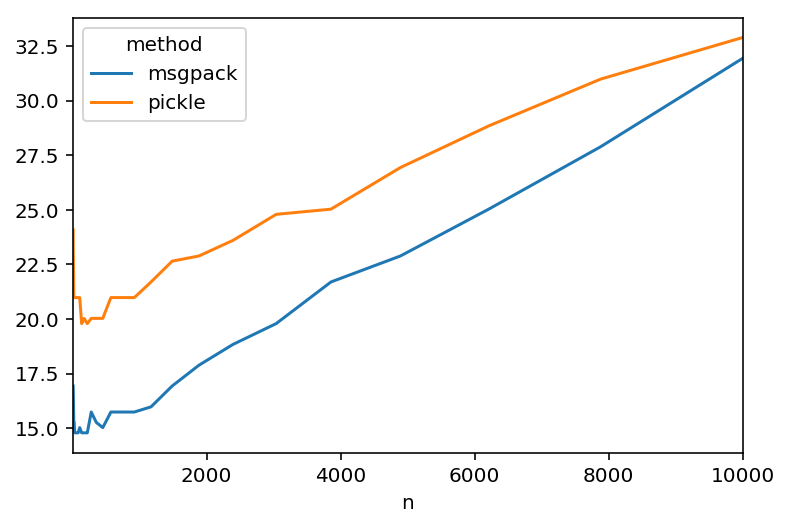

In [34]:
show.plot(y='dump_time (us)')

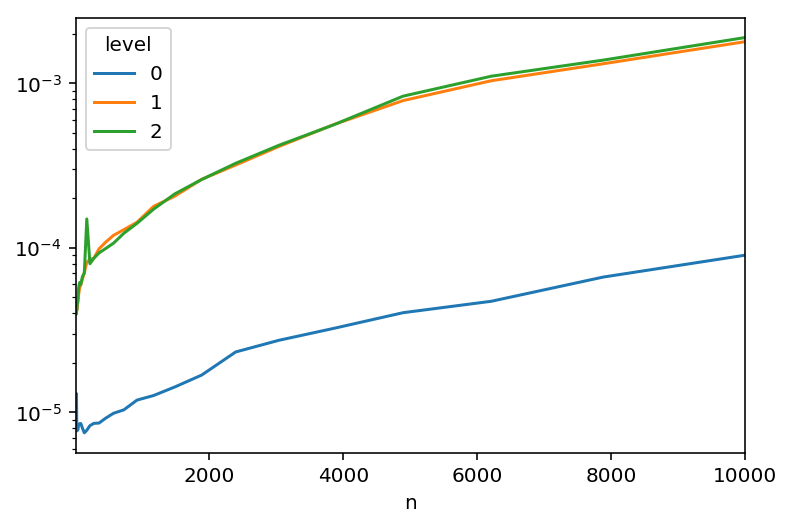

In [37]:
show = df.pivot_table(index='n', columns='level')
show.plot(y='compress_time', logy=True)

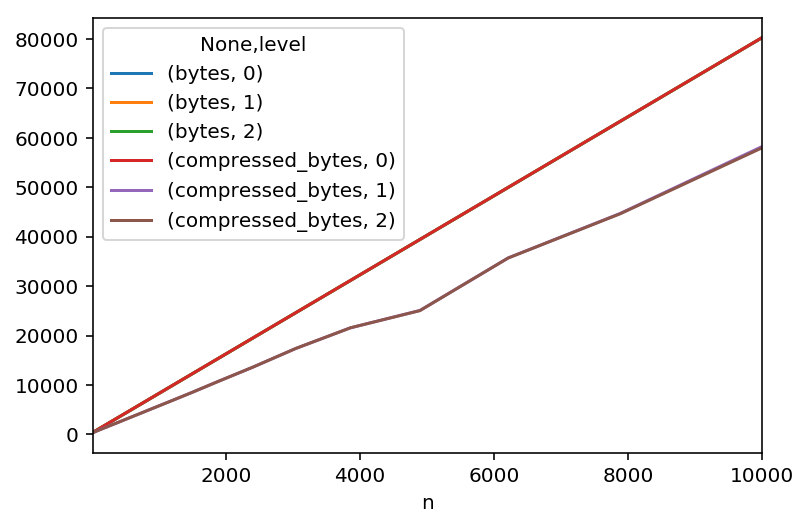

In [36]:
show.plot(y=['bytes', 'compressed_bytes'])